In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *

In [3]:
# Paths
DATADIR = '/storage/workspaces/giub_hydro/hydro/data/'
#DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_VAL = '2014'
YY_TEST = [2016, 2020]
sel_levels = [500, 850, 1000]
G = 9.80665 

In [4]:
# Read data
# Precipitation ERA5
pr = get_era5_data(DATADIR + '/ERA5/precipitation/day_grid1/*nc', DATE_START, DATE_END)
lon_pr=pr.lon
lat_pr=pr.lat
pr_Datarray = xr.DataArray(pr.tp) # to make the format as pr95
# Define precipitation extremes using the 95th
th95 = 0.95
pr95 = precip_exceedance_xarray(pr, th95)

Extracting data for the period 1979-01-01 - 2020-12-31


In [5]:
# Read covariates: RH, T2m, geopotential, wind (1x1deg)
z = get_era5_data(DATADIR + '/ERA5/geopotential/grid1/*.nc', DATE_START, DATE_END)
z = z.sel(level=sel_levels)
# Get Z in geopotential height (m)
z.z.values = z.z.values/G
# select the same coordinates values than precipitation
z_new = z.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [6]:
# temperature
t2m = get_era5_data(DATADIR + '/ERA5/temperature/grid1/Grid1_Daymean_era5_T2M_EU_19790101-20211231.nc', DATE_START, DATE_END)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)
# select the same coordinates values than precipitation
t2m_new = t2m.sel(lon=slice(min(lon_pr), max(lon_pr)))
t2m_1lev = t2m_new.expand_dims('level', axis=1)

Extracting data for the period 1979-01-01 - 2020-12-31


In [7]:
# relative humidity
rh = get_era5_data(DATADIR + '/ERA5/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END)
rh['time'] = pd.DatetimeIndex(rh.time.dt.date) # need to have the same time-format
rh = rh.sel(level=sel_levels)
rh_new = rh.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [8]:
# Wind components 850hpa
u850 = get_era5_data(DATADIR + '/ERA5/U_wind/day_grid1/*.nc', DATE_START, DATE_END)
u850['time'] = pd.DatetimeIndex(u850.time.dt.date)
u850_new = u850.sel(lon=slice(min(lon_pr), max(lon_pr)))
v850 = get_era5_data(DATADIR + '/ERA5/V_wind/day_grid1/*.nc', DATE_START, DATE_END)
v850['time'] = pd.DatetimeIndex(v850.time.dt.date)
v850_new = v850.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31


In [9]:
# checking dimensions
print('dimension of z',z_new.dims)
print('dimension of t2m:',t2m_new.dims)
print('dimension of rh:',rh_new.dims)
print('dimension of u:',u850_new.dims)
print('dimension of pr:',pr.dims)

dimension of z Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})
dimension of t2m: Frozen({'time': 15341, 'lon': 71, 'lat': 51})
dimension of rh: Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})
dimension of u: Frozen({'time': 15341, 'lon': 71, 'lat': 51})
dimension of pr: Frozen({'time': 15341, 'lon': 71, 'lat': 51})


In [10]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
#dic = OrderedDict({'z': 3, 'T2MMEAN':None, 'r':3})
bs = 32
dic = {'z': sel_levels,
       'T2MMEAN': None,
       'r': sel_levels}
     #  'u': None,
     #  'v': None}

In [11]:
# Data preparation
# For the data generator all variables have to be merged into a single dataset.
datasets = [z_new, t2m_new, rh_new]
ds = xr.merge(datasets)

In [12]:
# Split into training and test, then I will use DataGenerator class to get the validation
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))

In [13]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
lead_time = 5 # just in case of need
dg_train = DataGenerator_extended(ds_train.sel(time=slice('1979', '2014')), dic, lead_time, batch_size=bs, load=True)

Loading data into RAM


In [14]:
# Create a validation. Use the train mean and std for validation as well. And suffle
dg_val = DataGenerator_extended(ds_train.sel(time=slice('2015', '2015')), dic,lead_time, batch_size=bs,  mean=dg_train.mean, std=dg_train.std, load=True)

Loading data into RAM


In [15]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator_extended(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [16]:
# Prepare the data
X_train = xr.DataArray(dg_train.data)
X_val = xr.DataArray(dg_val.data)
X_test = xr.DataArray(dg_test.data)

In [17]:
X_train_input = np.array(X_train)
X_val_input = np.array(X_val)
X_test_input = np.array(X_test)

In [18]:
Y_train, Y_val, Y_test = get_Y_sets(pr95, YY_TRAIN, YY_VAL, YY_TEST)

In [19]:
X_train.shape

(13149, 51, 71, 7)

In [20]:
Y_train.shape

(13149, 51, 71)

In [21]:
# Basic model . Adding wind components it's too large..run out of memory
m0 = keras.models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    #layers.MaxPooling2D(pool_size=2),
    layers.Dense(1, activation='sigmoid')])

2022-01-29 14:28:17.037099: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-29 14:28:17.782428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10411 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


In [22]:
m0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 71, 16)        1024      
                                                                 
 batch_normalization (BatchN  (None, 51, 71, 16)       64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 51, 71, 1)         17        
                                                                 
Total params: 1,105
Trainable params: 1,073
Non-trainable params: 32
_________________________________________________________________


In [23]:
m0.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
h0= m0.fit(X_train_input, 
                Y_train,
                         epochs=10,
                         validation_data=(X_val_input, Y_val),
                         shuffle=True)

Epoch 1/10


2022-01-29 14:28:20.546589: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


411/411 [==============================] - 5s 6ms/step - loss: 0.3447 - accuracy: 0.9067 - val_loss: 0.2123 - val_accuracy: 0.9456
Epoch 2/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1959 - accuracy: 0.9504 - val_loss: 0.2103 - val_accuracy: 0.9456
Epoch 3/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1952 - accuracy: 0.9504 - val_loss: 0.2100 - val_accuracy: 0.9456
Epoch 4/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1949 - accuracy: 0.9504 - val_loss: 0.2093 - val_accuracy: 0.9456
Epoch 5/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1949 - accuracy: 0.9504 - val_loss: 0.2094 - val_accuracy: 0.9456
Epoch 6/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1948 - accuracy: 0.9504 - val_loss: 0.2095 - val_accuracy: 0.9456
Epoch 7/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1947 - accuracy: 0.9504 - val_loss: 0.2094 - val_accuracy: 0.9456
Epoch 8/10
411/41

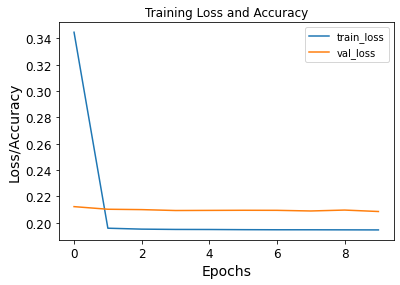

In [24]:
plot_hist(h0)

# U-Net architecture

In [25]:
# (still working on this...)
# encoder-decoder

In [26]:
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense,LSTM,Conv2D, BatchNormalization,Flatten, MaxPooling2D
from keras.layers import Conv2DTranspose,Concatenate,UpSampling2D,Cropping2D
from keras.layers import Input, Lambda, Reshape, Dropout, Activation

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [27]:
X_train[:,0:48,0:64].shape

(13149, 48, 64, 7)

In [28]:
# first try
#input_s = X_train.shape[1:]
input_s = X_train[:,0:48,0:64].shape[1:]
num_filters= 16
pad="same"
ks = (3,3)
activation='relu'

In [29]:
um = Unet1(input_s, num_filters, ks, activation)

Max pool 1: (None, 24, 32, 16)
Max pool 2: (None, 12, 16, 32)
Max pool 3: (None, 6, 8, 64)
Max pool 4: (None, 3, 4, 128)
conv 4 (None, 6, 8, 128)
Down sampling last layers output shape: (None, 3, 4, 256)
(None, 6, 8, 256)
Up-conv 1: (None, 6, 8, 128)
KerasTensor(type_spec=TensorSpec(shape=(None, 12, 16, 128), dtype=tf.float32, name=None), name='up_sampling2d_1/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_1'")
(None, 12, 16, 64)
Up_conv 2: (None, 12, 16, 64)
Conv 3 merger (None, 24, 32, 96)
Up-conv 3: (None, 24, 32, 32)
Up-conv 4: (None, 48, 64, 16)


In [30]:
um.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
h_unet = um.fit(X_train_input[:,0:48,0:64], 
                Y_train[:,0:48,0:64],
                         epochs=10,
                         validation_data=(X_val_input[:,0:48,0:64], Y_val[:,0:48,0:64]),
                         shuffle=True)

Epoch 1/10
411/411 [==============================] - 10s 19ms/step - loss: 0.1863 - accuracy: 0.9475 - val_loss: 0.1591 - val_accuracy: 0.9445
Epoch 2/10
411/411 [==============================] - 7s 17ms/step - loss: 0.1342 - accuracy: 0.9530 - val_loss: 0.1362 - val_accuracy: 0.9507
Epoch 3/10
411/411 [==============================] - 7s 17ms/step - loss: 0.1222 - accuracy: 0.9556 - val_loss: 0.1288 - val_accuracy: 0.9520
Epoch 4/10
411/411 [==============================] - 7s 17ms/step - loss: 0.1159 - accuracy: 0.9571 - val_loss: 0.1250 - val_accuracy: 0.9529
Epoch 5/10
411/411 [==============================] - 7s 17ms/step - loss: 0.1117 - accuracy: 0.9582 - val_loss: 0.1203 - val_accuracy: 0.9544
Epoch 6/10
411/411 [==============================] - 7s 17ms/step - loss: 0.1085 - accuracy: 0.9591 - val_loss: 0.1189 - val_accuracy: 0.9547
Epoch 7/10
411/411 [==============================] - 7s 17ms/step - loss: 0.1055 - accuracy: 0.9600 - val_loss: 0.1170 - val_accuracy: 0.955

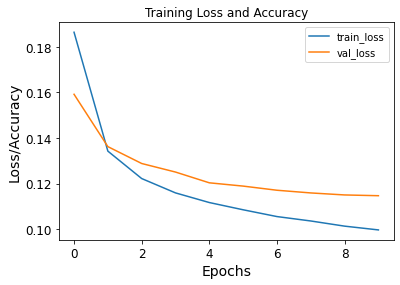

In [32]:
plot_hist(h_unet)

## Unet-2 

In [35]:
output_channels=1
um2 = Unet2(input_s, output_channels)
um2=um2.build_model()

In [36]:
um2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 64, 7)]  0           []                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 48, 64, 64)   4096        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 48, 64, 64)  256         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_9 (Dropout)            (None, 48, 64, 64)   0           ['batch_normalization_18[0]

In [37]:
um2.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
h_unet2 = um2.fit(X_train_input[:,0:48,0:64], 
                Y_train[:,0:48,0:64],
                         epochs=10,
                         validation_data=(X_val_input[:,0:48,0:64], Y_val[:,0:48,0:64]),
                         shuffle=True)

Epoch 1/10
411/411 [==============================] - 35s 77ms/step - loss: 0.1645 - accuracy: 0.9472 - val_loss: 0.1691 - val_accuracy: 0.9283
Epoch 2/10
411/411 [==============================] - 30s 72ms/step - loss: 0.1210 - accuracy: 0.9553 - val_loss: 0.1502 - val_accuracy: 0.9367
Epoch 3/10
411/411 [==============================] - 30s 72ms/step - loss: 0.1115 - accuracy: 0.9577 - val_loss: 0.1187 - val_accuracy: 0.9533
Epoch 4/10
411/411 [==============================] - 30s 72ms/step - loss: 0.1054 - accuracy: 0.9593 - val_loss: 0.1188 - val_accuracy: 0.9533
Epoch 5/10
411/411 [==============================] - 30s 72ms/step - loss: 0.1008 - accuracy: 0.9607 - val_loss: 0.1095 - val_accuracy: 0.9574
Epoch 6/10
411/411 [==============================] - 30s 72ms/step - loss: 0.0976 - accuracy: 0.9617 - val_loss: 0.1065 - val_accuracy: 0.9582
Epoch 7/10
411/411 [==============================] - 30s 72ms/step - loss: 0.0949 - accuracy: 0.9626 - val_loss: 0.1075 - val_accuracy:

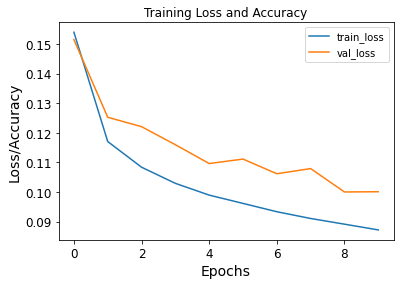

In [31]:
plot_hist(h_unet2)

In [56]:
# make predictions
pred = um2.predict(X_test_input[:,0:48,0:64])

In [57]:
# Convert to xr.array
pred = xr.DataArray(pred.reshape(1827,48,64), coords=[ds_test.time, ds_test.lat[0:48], ds_test.lon[0:64]],dims=["time",'lat','lon'])
true = xr.DataArray(Y_test[:,0:48,0:64], coords=[ds_test.time, ds_test.lat[0:48], ds_test.lon[0:64]],dims=["time",'lat','lon'])

In [67]:
rmse = compute_weighted_rmse(true,pred) #OK, I need to check this out..

## ResNet

In [147]:
inputs = Input(shape=input_s)
out_s = input_s[0]*input_s[1]

In [148]:
x = conv_batchnorm_relu(inputs, filters=64, kernel_size=3, strides=2)
x.shape
x = MaxPool2D(pool_size = 3, strides =2)(x)
x.shape

TensorShape([None, 11, 15, 64])

In [149]:
x = resnet_block(x, filters=64, reps =3, strides=1)
#x = resnet_block(x, filters=128, reps =4, strides=2)
#x = resnet_block(x, filters=256, reps =6, strides=2)
#x = resnet_block(x, filters=512, reps =3, strides=2)
x = GlobalAvgPool2D()(x)

In [150]:
x.shape

TensorShape([None, 256])

In [151]:
output = Dense(out_s, activation ='sigmoid')(x)

In [161]:
# Build the model
testmodel = Model(inputs=inputs, outputs=output)
testmodel.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 48, 64, 7)]  0           []                               
                                                                                                  
 conv2d_317 (Conv2D)            (None, 24, 32, 64)   4096        ['input_17[0][0]']               
                                                                                                  
 batch_normalization_311 (Batch  (None, 24, 32, 64)  256         ['conv2d_317[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_284 (ReLU)               (None, 24, 32, 64)   0           ['batch_normalization_311[0

In [163]:
testmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [164]:
Y_train_res =  Y_train[:,0:48,0:64].reshape(13149, 48*64)
Y_val_res = Y_val[:,0:48,0:64].reshape(365, 48*64)

In [166]:
h_res = testmodel.fit(X_train_input[:,0:48,0:64], 
                Y_train_res,
                         epochs=10,
                         validation_data=(X_val_input[:,0:48,0:64], Y_val_res),
                         shuffle=True)

Epoch 1/10
411/411 [==============================] - 12s 24ms/step - loss: 0.1888 - accuracy: 6.0841e-04 - val_loss: 0.1947 - val_accuracy: 0.0000e+00
Epoch 2/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1644 - accuracy: 0.0013 - val_loss: 0.1735 - val_accuracy: 0.0000e+00
Epoch 3/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1525 - accuracy: 0.0018 - val_loss: 0.1637 - val_accuracy: 0.0000e+00
Epoch 4/10
411/411 [==============================] - 8s 21ms/step - loss: 0.1448 - accuracy: 0.0012 - val_loss: 0.1546 - val_accuracy: 0.0027
Epoch 5/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1396 - accuracy: 0.0019 - val_loss: 0.1538 - val_accuracy: 0.0027
Epoch 6/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1352 - accuracy: 0.0017 - val_loss: 0.1445 - val_accuracy: 0.0027
Epoch 7/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1317 - accuracy: 0.0021 - val_loss: 0.1433 - val

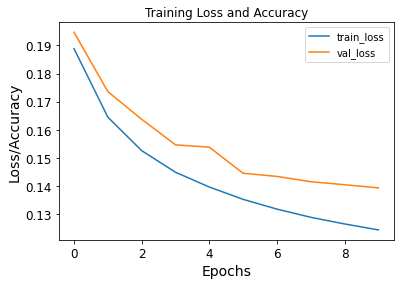

In [167]:
plot_hist(h_res)